# Twitter Sentiment Analysis using RNN (LSTM/GRU)
**Files included:** `/mnt/twitter_training.csv`

This notebook follows the task list in *Week 31 - Task to be performed* and performs:
- Data loading & cleaning
- EDA (statistics, visualizations, word frequencies, wordclouds)
- Feature engineering (tokenization, embeddings)
- Build and train an RNN model (LSTM/GRU) for sentiment classification
- Evaluation and improvement suggestions

> Run each cell in sequence. Some optional libraries (e.g., `wordcloud`) may need to be installed — instructions included below.


In [27]:
# Basic imports and environment check
import os
print('Python executable:', os.sys.executable)
print('Input tweet csv', os.listdir('/mnt'))

Python executable: /usr/bin/python3
Input tweet csv ['twitter_training.csv']


In [3]:
# If you need wordcloud or textblob, uncomment and run the following.
!pip install wordcloud textblob nltk tensorflow scikit-learn --quiet

# Download NLTK data (if not already installed)
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# Load the dataset
import pandas as pd
path = '/mnt/twitter_training.csv'
df = pd.read_csv(path)
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (74682, 4)


,ID,TOPIC,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [16]:
# Data cleaning
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [ps.stem(w) for w in text.split() if w not in stop_words]
    return ' '.join(tokens)

print('Columns:', df.columns.tolist())

text_col = "Tweet"

print('Using text column:', text_col)

df['clean_text'] = df[text_col].astype(str).apply(clean_text)
print('Missing values before:', df.isnull().sum().to_dict())
df = df.drop_duplicates()
df = df.dropna(subset=['clean_text'])
print('Dataset shape after cleaning:', df.shape)
df.head()

Columns: ['ID', 'TOPIC', 'Sentiment', 'Tweet']
Using text column: Tweet
Missing values before: {'ID': 0, 'TOPIC': 0, 'Sentiment': 0, 'Tweet': 691, 'clean_text': 0}
Dataset shape after cleaning: (71939, 5)


,ID,TOPIC,Sentiment,Tweet,clean_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im get borderland murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,come border kill
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im get borderland kill
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im come borderland murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im get borderland 2 murder


In [17]:
# Sentiment label handling
label_col = "Sentiment"

print('Label column:', label_col)
if label_col is None:
    print('No explicit label column found. Please set label column manually.')
else:
    print(df[label_col].value_counts(dropna=False))

Label column: Sentiment
Sentiment
Negative      21778
Positive      19803
Neutral       17781
Irrelevant    12577
Name: count, dtype: int64


## Exploratory Data Analysis (EDA)

Sentiment
Negative      21778
Positive      19803
Neutral       17781
Irrelevant    12577
Name: count, dtype: int64


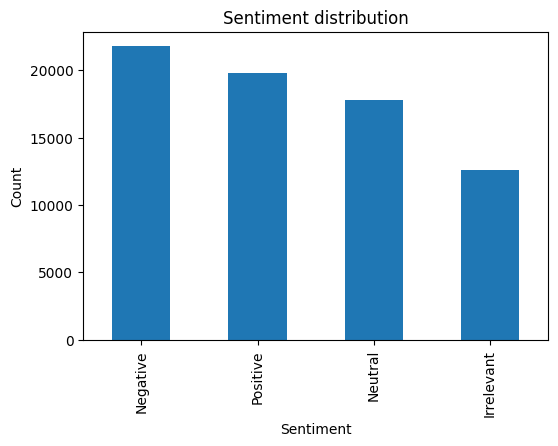

In [18]:
# Basic statistics and sentiment distribution
import matplotlib.pyplot as plt
import numpy as np

if 'label_col' in globals() and label_col in df.columns:
    vc = df[label_col].value_counts()
    print(vc)
    plt.figure(figsize=(6,4))
    vc.plot(kind='bar')
    plt.title('Sentiment distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()
else:
    print('Label column not found; skip sentiment distribution plot.')

<Figure size 800x500 with 0 Axes>

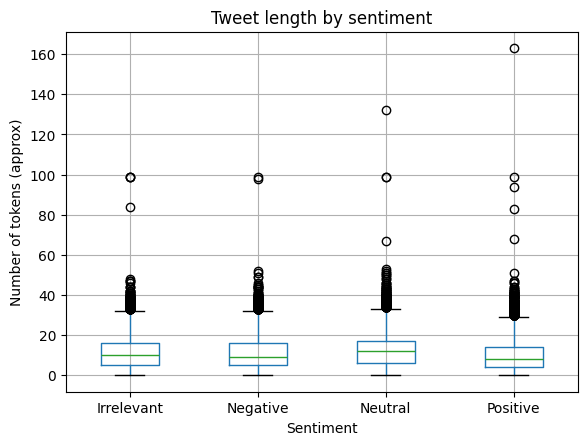

In [19]:
# Tweet length vs sentiment
df['tweet_len'] = df['clean_text'].apply(lambda x: len(x.split()))
if label_col in df.columns:
    plt.figure(figsize=(8,5))
    df.boxplot(column='tweet_len', by=label_col)
    plt.suptitle('')
    plt.title('Tweet length by sentiment')
    plt.ylabel('Number of tokens (approx)')
    plt.show()
else:
    print('Label column not found; skip length vs sentiment plot.')

In [20]:
# Top words per sentiment
from collections import Counter
def top_n_words(series, n=20):
    cnt = Counter()
    for s in series:
        cnt.update(s.split())
    return cnt.most_common(n)

if label_col in df.columns:
    for label in df[label_col].unique():
        words = top_n_words(df[df[label_col]==label]['clean_text'], n=20)
        print('\nTop words for', label, words[:10])
else:
    print('Label column not found; showing top words overall:')
    print(top_n_words(df['clean_text'], n=30)[:20])


Top words for Positive [('game', 3254), ('play', 2490), ('love', 2028), ('com', 1842), ('good', 1563), ('like', 1429), ('2', 1314), ('thank', 1291), ('get', 1276), ('pic', 1271)]

Top words for Neutral [('com', 4080), ('game', 1926), ('johnson', 1892), ('play', 1514), ('2', 1481), ('amazon', 1333), ('get', 1192), ('like', 986), ('facebook', 971), ('one', 888)]

Top words for Negative [('game', 4594), ('get', 2364), ('fuck', 2360), ('play', 2066), ('com', 1814), ('like', 1678), ('shit', 1494), ('fix', 1449), ('twitter', 1316), ('pic', 1286)]

Top words for Irrelevant [('com', 1809), ('player', 1374), ('game', 1226), ('ban', 1205), ('like', 1079), ('see', 1055), ('play', 824), ('love', 785), ('peopl', 764), ('go', 763)]


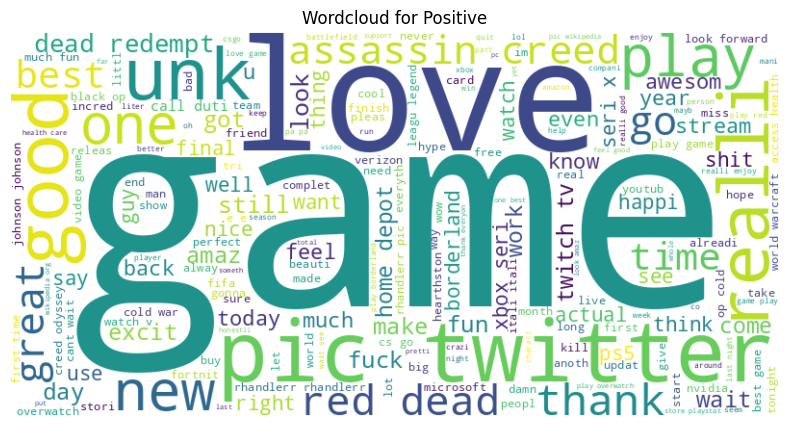

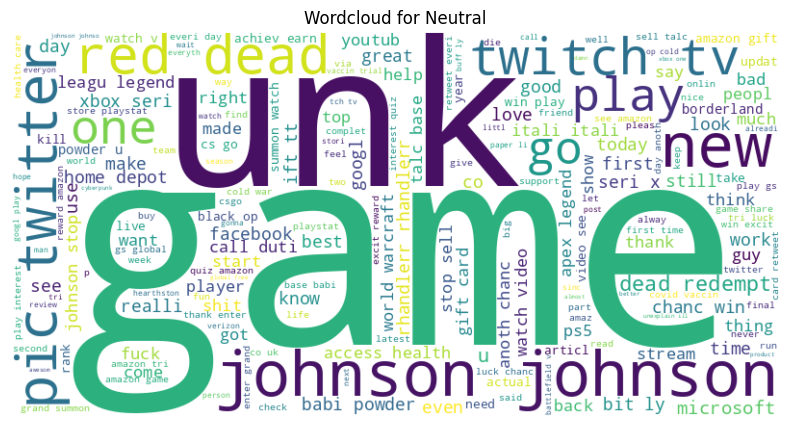

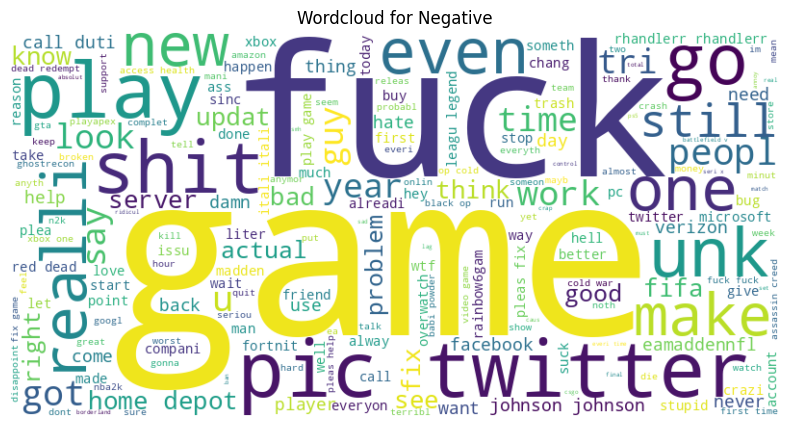

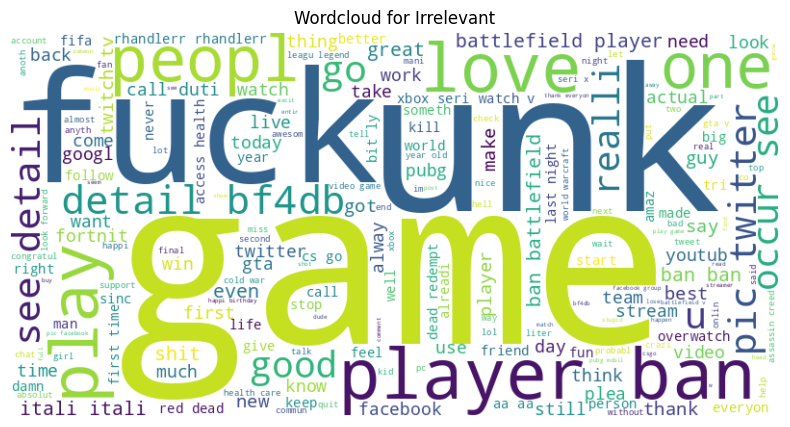

In [21]:
# Wordclouds (optional)
try:
    from wordcloud import WordCloud
    if label_col in df.columns:
        for label in df[label_col].unique():
            text = ' '.join(df[df[label_col]==label]['clean_text'])
            wc = WordCloud(width=800, height=400, background_color='white').generate(text)
            plt.figure(figsize=(10,5))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Wordcloud for {label}')
            plt.show()
    else:
        text = ' '.join(df['clean_text'])
        wc = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title('Wordcloud (all tweets)')
        plt.show()
except Exception as e:
    print('WordCloud not available or failed:', e)
    print('You can install it with: pip install wordcloud')

## Feature Engineering & Model (RNN with Embedding + LSTM/GRU)

In [22]:
# Prepare data for model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

if label_col not in df.columns:
    raise ValueError('Label column not found. Please set the variable `label_col` to the correct column name and re-run.')

labels = df[label_col].astype(str)
label_map = {lab:i for i,lab in enumerate(sorted(labels.unique()))}
df['label_num'] = labels.map(label_map)
print('Label map:', label_map)

X = df['clean_text'].values
y = df['label_num'].values

max_words = 20000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
maxlen = 50
X_pad = pad_sequences(sequences, maxlen=maxlen, padding='post')

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42, stratify=y)
print('Shapes:', X_train.shape, X_test.shape)

Label map: {'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}
Shapes: (57551, 50) (14388, 50)


In [39]:
# Build RNN model (LSTM)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
#Exp4
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
vocab_size = min(max_words, len(tokenizer.word_index)+1)
embedding_dim = 100
#Exp 1
#def build_lstm_model():
#    model = Sequential()
#    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
#    model.add(Bidirectional(LSTM(64, return_sequences=False)))
#    model.add(Dropout(0.5))
#    model.add(Dense(32, activation='relu'))
#    model.add(Dense(len(label_map), activation='softmax'))
#    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#    return model
#Exp 1 showed overfitting. So adjusting hyperparameters
#Exp 3 Correct output dense layer to have softmax
#Exp 4 Add recurrent_dropout=0.25
#.     Add kernel_regularizer in hidden Dense layer

def build_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    model.add(Bidirectional(LSTM(32, return_sequences=False, recurrent_dropout=0.25)))
    model.add(Dropout(0.5))
    #model.add(Dense(16, activation='relu'))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Dropout(0.25))
    model.add(Dense(len(label_map), activation='softmax'))
    opt = Adam(learning_rate=1e-3)   # consider lowering to 5e-4 or 1e-4 if unstable
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = build_lstm_model()
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Train the model
#Exp4 Adjust callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.4549 - loss: 1.2118
Epoch 1: val_loss improved from inf to 0.76528, saving model to best_model.h5


810/810 ━━━━━━━━━━━━━━━━━━━━ 113s 129ms/step - accuracy: 0.4551 - loss: 1.2116 - val_accuracy: 0.7146 - val_loss: 0.7653 - learning_rate: 0.0010
Epoch 2/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7565 - loss: 0.6883
Epoch 2: val_loss improved from 0.76528 to 0.58964, saving model to best_model.h5


810/810 ━━━━━━━━━━━━━━━━━━━━ 143s 131ms/step - accuracy: 0.7565 - loss: 0.6883 - val_accuracy: 0.7844 - val_loss: 0.5896 - learning_rate: 0.0010
Epoch 3/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8247 - loss: 0.5047
Epoch 3: val_loss improved from 0.58964 to 0.54548, saving model to best_model.h5


810/810 ━━━━━━━━━━━━━━━━━━━━ 139s 127ms/step - accuracy: 0.8247 - loss: 0.5047 - val_accuracy: 0.7995 - val_loss: 0.5455 - learning_rate: 0.0010
Epoch 4/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8534 - loss: 0.4210
Epoch 4: val_loss improved from 0.54548 to 0.53268, saving model to best_model.h5


810/810 ━━━━━━━━━━━━━━━━━━━━ 103s 127ms/step - accuracy: 0.8534 - loss: 0.4210 - val_accuracy: 0.8068 - val_loss: 0.5327 - learning_rate: 0.0010
Epoch 5/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8677 - loss: 0.3741
Epoch 5: val_loss improved from 0.53268 to 0.52563, saving model to best_model.h5


810/810 ━━━━━━━━━━━━━━━━━━━━ 148s 134ms/step - accuracy: 0.8677 - loss: 0.3741 - val_accuracy: 0.8191 - val_loss: 0.5256 - learning_rate: 0.0010
Epoch 6/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8748 - loss: 0.3495
Epoch 6: val_loss improved from 0.52563 to 0.51355, saving model to best_model.h5


810/810 ━━━━━━━━━━━━━━━━━━━━ 103s 127ms/step - accuracy: 0.8748 - loss: 0.3495 - val_accuracy: 0.8211 - val_loss: 0.5136 - learning_rate: 0.0010
Epoch 7/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8853 - loss: 0.3182
Epoch 7: val_loss did not improve from 0.51355
810/810 ━━━━━━━━━━━━━━━━━━━━ 102s 126ms/step - accuracy: 0.8853 - loss: 0.3182 - val_accuracy: 0.8285 - val_loss: 0.5256 - learning_rate: 0.0010
Epoch 8/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8915 - loss: 0.3006
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: val_loss did not improve from 0.51355
810/810 ━━━━━━━━━━━━━━━━━━━━ 142s 127ms/step - accuracy: 0.8915 - loss: 0.3006 - val_accuracy: 0.8290 - val_loss: 0.5363 - learning_rate: 0.0010
Epoch 9/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9019 - loss: 0.2722
Epoch 9: val_loss did not improve from 0.51355
810/810 ━━━━━━━━━━━━━━━━━━━━ 103s 127ms/step - accuracy: 0.9019 - loss: 0.2722 - va

In [42]:
# Evaluate model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print(classification_report(y_test, y_pred, target_names=[k for k,v in sorted(label_map.items(), key=lambda x:x[1])]))
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)

450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step
              precision    recall  f1-score   support

  Irrelevant       0.80      0.80      0.80      2515
    Negative       0.84      0.85      0.84      4356
     Neutral       0.87      0.81      0.84      3556
    Positive       0.80      0.84      0.82      3961

    accuracy                           0.83     14388
   macro avg       0.83      0.82      0.82     14388
weighted avg       0.83      0.83      0.83     14388

Confusion matrix:
 [[2018  173  108  216]
 [ 163 3682  175  336]
 [ 154  236 2883  283]
 [ 196  292  165 3308]]


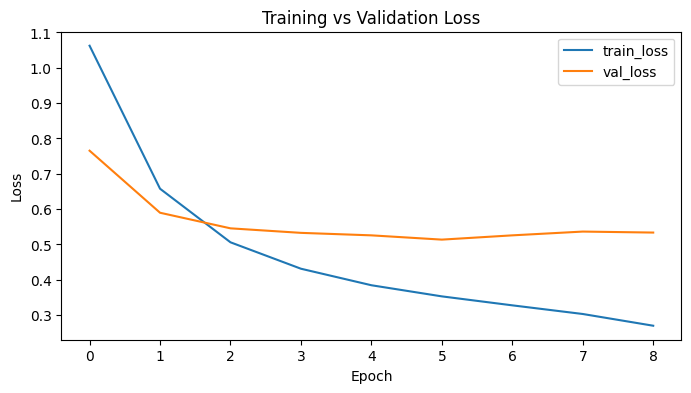

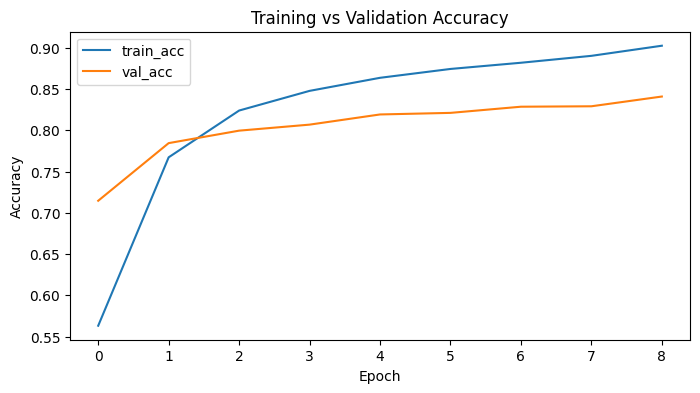

In [43]:
# Plot learning curves
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

## Model improvement suggestions
- Try using pre-trained embeddings (GloVe, FastText) — load embeddings and set `Embedding(..., weights=[...], trainable=False)` initially.
- Use hyperparameter tuning (Keras Tuner or scikit-learn's GridSearch via wrappers).
- Try GRU instead of LSTM or stack multiple RNN layers.
- Balance classes using class weights or oversampling if dataset is imbalanced.
- Experiment with different `maxlen`, `embedding_dim`, and recurrent hidden sizes.


## Presentation & Report
Include the following in your final report/presentation:
- Data description and preprocessing steps
- EDA findings (plots, wordclouds, key words)
- Model architecture diagram and hyperparameters
- Performance metrics and confusion matrix
- Demonstration on sample tweets (a small function to predict sentiment of new text)


In [ ]:
# Save the tokenizer and model (optional)
# tokenizer_json = tokenizer.to_json()
# with open('/mnt/data/tokenizer.json','w') as f:
#     f.write(tokenizer_json)
# model.save('/mnt/data/sentiment_rnn_model.h5')
print('You can save tokenizer and model by uncommenting the lines above.')